<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/2], Loss: 0.0207
Epoch [2/2], Loss: 0.0151


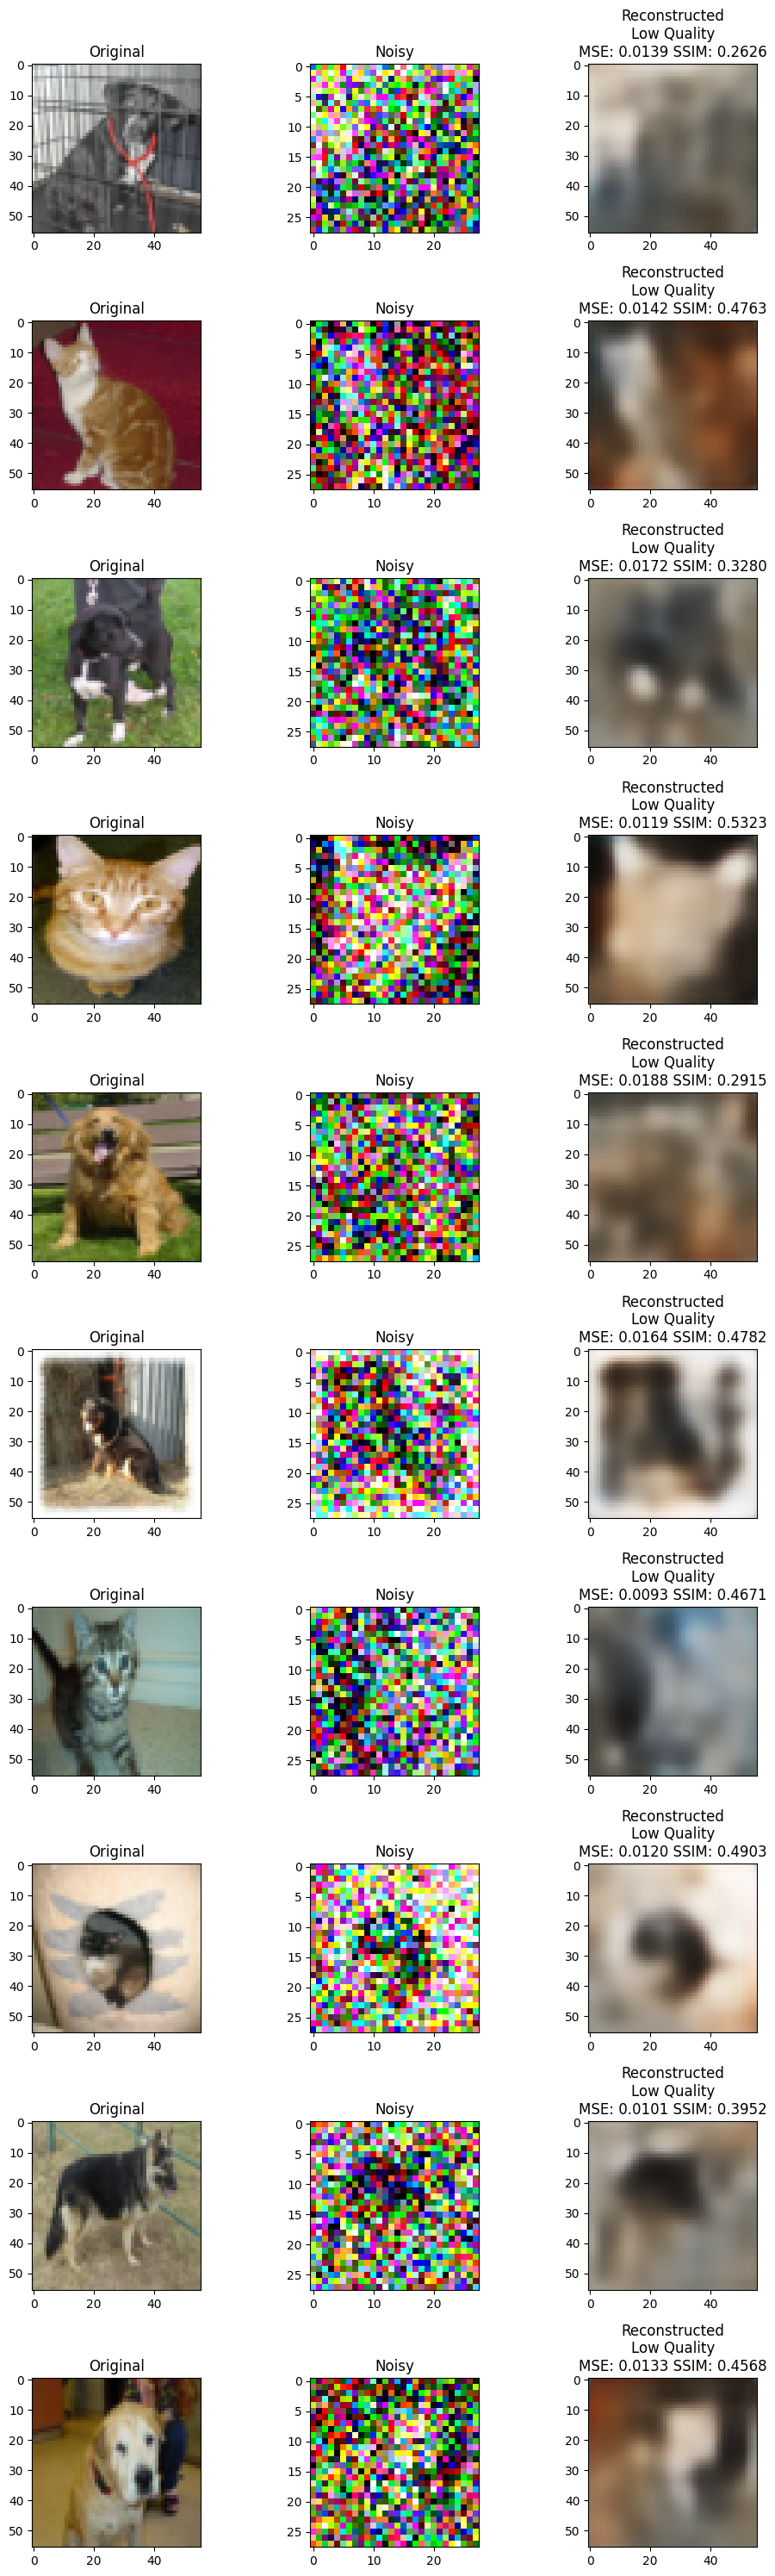

High Quality: 0 images
Moderate Quality: 0 images
Low Quality: 0 images


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from google.colab import drive

# Connecting to Google Drive
drive.mount("/content/drive")

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, directory, input_size=(28, 28), target_size=(56, 56)):
        self.directory = directory
        self.input_size = input_size
        self.target_size = target_size
        self.filenames = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform_input = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor()
        ])
        self.transform_target = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        img = Image.open(img_path).convert("RGB")
        input_img = self.transform_input(img)
        target_img = self.transform_target(img)
        return input_img, target_img

# Create Dataset and Dataloader
batch_size = 64
train_dataset = ImageDataset("/content/drive/My Drive/train/")
test_dataset = ImageDataset("/content/drive/My Drive/test1/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 56x56 → Output: 56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 56x56 → 28x28

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 28x28 → 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 28x28 → 14x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 14x14 → 14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)          # 14x14 → 7x7
        )


        # Decoder with Correct Upsampling to 56x56
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 7x7 → 14x14
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14x14 → 28x28
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 28x28 → 56x56
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output scaled to [0, 1]
        )



    def forward(self, x):
        # ✅ Upscale input from 28x28 to 56x56
        x = F.interpolate(x, size=(56, 56), mode='bilinear', align_corners=False)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        # Add noise to input
        noisy_input = input_batch + 0.5 * torch.randn_like(input_batch)
        noisy_input = torch.clamp(noisy_input, 0., 1.)

        optimizer.zero_grad()
        outputs = model(noisy_input)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Save the model
torch.save(model.state_dict(), "/content/drive/My Drive/image_upscaler.pth")

# Evaluation and Visualization
model.eval()
mse_values = []
ssim_values = []
categories = {"High Quality": [], "Moderate Quality": [], "Low Quality": []}

mse_thresholds = [0.005, 0.02]
ssim_thresholds = [0.85, 0.65]

fig, axes = plt.subplots(10, 3, figsize=(10, 30))  # 10 rows, 3 columns
image_count = 0

for input_batch, target_batch in test_loader:
    if image_count >= 50:
        break

    noisy_input = input_batch + 0.5 * torch.randn_like(input_batch)
    noisy_input = torch.clamp(noisy_input, 0., 1.)

    with torch.no_grad():
        output = model(noisy_input.to(device)).cpu().numpy()

    for i in range(input_batch.size(0)):
        if image_count >= 50:
            break

        original = target_batch[i].permute(1, 2, 0).numpy()
        noisy = noisy_input[i].permute(1, 2, 0).numpy()
        recon = output[i].transpose(1, 2, 0)

        mse = mean_squared_error(original.flatten(), recon.flatten())
        ssim_index = ssim(original, recon, data_range=1.0, channel_axis=-1)

        if mse < mse_thresholds[0] and ssim_index > ssim_thresholds[0]:
            category = "High Quality"
        elif mse < mse_thresholds[1] and ssim_index > ssim_thresholds[1]:
            category = "Moderate Quality"
        else:
            category = "Low Quality"
        categories[category].append(image_count)
        # Display images
        axes[image_count, 0].imshow(original)
        axes[image_count, 0].set_title(f"Original")
        axes[image_count, 1].imshow(noisy)
        axes[image_count, 1].set_title("Noisy")
        axes[image_count, 2].imshow(recon)
        axes[image_count, 2].set_title(f"Reconstructed\n{category}\nMSE: {mse:.4f} SSIM: {ssim_index:.4f}")

        image_count += 1

plt.tight_layout()
plt.show()

# Summary
for category, indices in categories.items():
    print(f"{category}: {len(indices)} images")
